In [24]:
import pandas as pd

from log_processing import process_log
import matplotlib.pyplot as plt

In [25]:
log_file = "../backtests/test.log"

trader_data, products_data, activities, trades = process_log(log_file)

In [26]:
rf = activities[activities["product"] == "RAINFOREST_RESIN"]

(array([ 153.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,   37.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,  259.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0., 1006.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         545.]),
 array([ 9998.  ,  9998.07,  9998.14,  9998.21,  9998.28,  9998.35,
         9998.42,  9998.49,  9998.56,  9998.63,  9998.7 ,  9998.77,
         9998.84,  9998.91,  9998.98,  9999.05,  9999.12,  9999.19

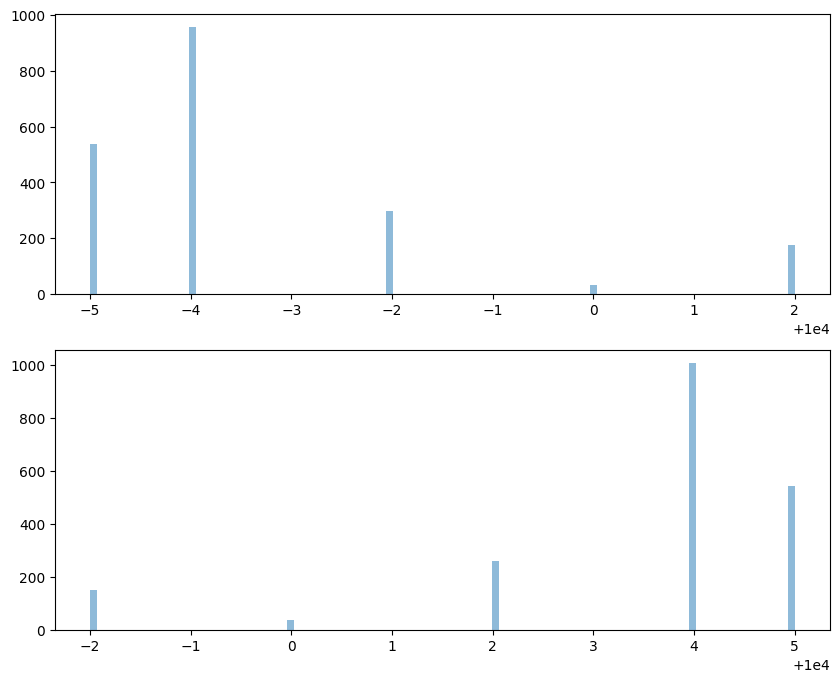

In [29]:
rf_bb = rf["bid_price_1"]
rf_ba = rf["ask_price_1"]

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].hist(rf_bb, bins=100, alpha=0.5, label="Bid Price")
axs[1].hist(rf_ba, bins=100, alpha=0.5, label="Bid Price")